# Oncodriveclustl

In [1]:
%matplotlib inline

import gzip
from collections import defaultdict

import numpy as np
from intervaltree import IntervalTree
from scipy.signal import argrelmax
import math as m

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

### Parse regions

In [2]:
input_regions = '/home/carnedo/projects/oncodriveclustl/inputs/regions/02_cds.regions.gz'

In [3]:
def regions(input_regions): 
    """
    Parse input regions
    :param input_regions: path. File name? chr \t start \t end \t strand  \t ensembl id \t ensembl id \t symbol 
    :return: dictionary of dictionary of intervaltrees (trees) containing intervals of genomic regions by chromosome. 
    Dictionary containing a list of tuples with the coding sequences of each gene. 
    """
    trees = defaultdict(IntervalTree)
    regions_d = defaultdict(list)

    with gzip.open(input_regions, 'rb') as fd: # rb for binary <-- gz
        for line in fd:
            line = line.decode() # binary to readable
            chromosome, start, end, strand, _, _, symbol = line.strip().split('\t') 
            trees[chromosome][int(start): int(end) + 1] = symbol  # int, +1 end 
            regions_d[symbol].append((int(start), int(end) + 1))
            
    return trees, regions_d

In [4]:
trees, regions_d = regions(input_regions)

### Read mutations file and intersect with regions

In [5]:
input_mutations = '/home/carnedo/projects/oncodriveclustl/inputs/mutations/pancanatlas/BLCA.txt'

In [6]:
def read_mutations(input_mutations, trees): 
    """
    Parse substitution mutations
    :param input_mutations: path. File name? chr \t position \t ref \t alt \t sample \t mut_type \t tumor \t signature \ transcript \ symbol
    :param trees: dictionary of dictionary of intervaltrees containing intervals of genomic regions by chromosome.
    :return: dictionary containing a list of mutations by gene
    """

    mutations_d = defaultdict(list)

    with open(input_mutations, 'r') as fd:
        next(fd) # don't read header
        for line in fd:
            chromosome, position, ref, alt, sample, mut_type, tumor = line.strip().split('\t')[:7]
            if trees[chromosome][int(position)] != set() and mut_type == 'subs': # intersect only subs
                results = trees[chromosome][int(position)]
                for res in results:
                    mutations_d[res.data].append(int(position)) # dict: key = gene, value = list of mutations
                    
    return mutations_d

In [7]:
mutations_d = read_mutations(input_mutations, trees)

### Smoothing function

In [8]:
def tukey(window):
    """Tukey smoothing function
    :param window: int, length of the smoothing window
    :return: numpy array. The elements sum to 1
    """
    half_window = window // 2
    tukey = lambda x: np.maximum(1 - x ** 2, 0) ** 2
    filter_ = tukey(np.arange(-half_window, half_window + 1) / (half_window + 1))
    filter_ = filter_ / sum(filter_)
    return filter_

### Smooth region

In [9]:
def smoothing(symbol, mutations, window):
    """
    
    :param symbol: gene identifier
    :param mutations: list of mutations (genomic position) of the analyzed gene
    :param window: window (integer) of smoothing function
    :return: 
        symbol: gene identifier; 
        genomic: np.array containing all postions in the region analyzed
        binary: np.array of length == genomic, contains the sum of smoothing scores of all mutations in the region
        mutations: np.array of length == genomic, contains the number of mutations by position 
    """
    
    # Define smoothing window 
    window += 1 - window % 2
    smooth = tukey(window)
    
    genomic = np.array([])  # genomic coordinates

    for element in regions_d[symbol]:   # iterate through tuples of coordinates 
        for position in range(element[0],element[1]+1): 
            genomic = np.append(genomic, [position])

    binary = np.zeros(len(genomic) + window - 1)   # binary cds with borders added
    mutations_a = np.zeros(len(genomic) + window - 1)   # mutations cds with borders added

    indeces = np.searchsorted(np.array(genomic), mutations)

    for index in indeces:
        binary[index: index + window] += smooth
        mutations_a[index + window // 2] += 1


    # Remove the extra bases at the beginning and at the end
    binary = binary[window // 2: - window // 2 + 1]
    mutations_a = mutations_a[window // 2: - window // 2 + 1]
   
    return symbol, genomic, binary, mutations_a

In [10]:
symbol, genomic, binary, mutations = smoothing(symbol='TP53', mutations=mutations_d['TP53'], window=50)

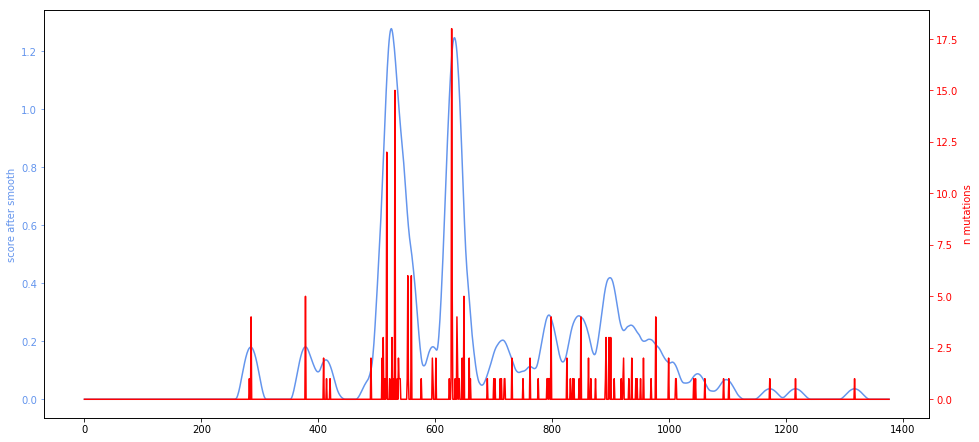

In [11]:
# Plot results
plt.figure(figsize=(20, 7.5))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=4)

ax1.plot(binary, c='cornflowerblue')
ax1.set_ylabel('score after smooth', color='cornflowerblue')

ax2 = ax1.twinx()
ax2.plot(mutations, c='red')
ax2.set_ylabel('n mutations', color='red')

length = len(genomic)

ax1.tick_params('y', colors='cornflowerblue')
ax2.tick_params('y', colors='red')

## Clusters

- Find local maximum and minimum after smoothing for whole cds, according to smoothing score
- Define raw clusters: min(left), max, min(right) ----> Add filter? (ex. clusters wit max > smoothing score of 1 mutation)
- Starting from first maximum in the sequence, search for other relative maximum close to its min(right) border. 
- If there is one, check which of both maximum has a higher smoothing score and merge clusters by updating borders of the highest maximum. The lowest maximum (cluster) is removed from the dictionary of clusters. Iterate through all clusters until no updates are observed. 
- Score clusters. Two scores implemented: using position of smoothing maximum or mutation maximum within the cluster. 

### Find max and min

In [12]:
def find_locals(binary): 
    """
    Find local maximum and minimum 
    :param binary: np.array of length == genomic, contains the sum of smoothing scores of all mutations in the region
    :return: 
        indexes: list of lists [0 == min or 1 == max, position in cds, smoothing score] containing max and min
        plot_max: np.array for plot, 1 where a max is found, else nan
        plot_min: np.array for plot, 1 where a min is found, else nan
    """
    
    indexes = []
    plot_max = np.zeros(len(binary))
    plot_min = np.zeros(len(binary))
        
    # Iterate through the binary array
    for index in range(0, len(binary) - 1): 
            
            # Max
            # when max score is equal in contiguous positions, assumes the first as max
            if binary[index] > binary[index - 1] and binary[index] >= binary[index + 1]: 
                indexes.append([1, index, binary[index]])
                plot_max[index] +=1        
                 
            # Min
            elif binary[index] <= binary[index - 1] and binary[index] <= binary[index + 1]: 
                # get a 'false' minimum where minimum score is equal in contiguous positions
                if binary[index - 1] or binary[index + 1] != 0: 
                    indexes.append([0, index, binary[index]])
                    plot_min[index] +=1

    
    # Change 0 to nan for matplotlib        
    plot_max[ plot_max==0.0 ] = np.nan
    plot_min[ plot_min==0.0 ] = np.nan 


    return indexes, plot_max, plot_min

In [13]:
indexes, plot_max, plot_min = find_locals(binary)

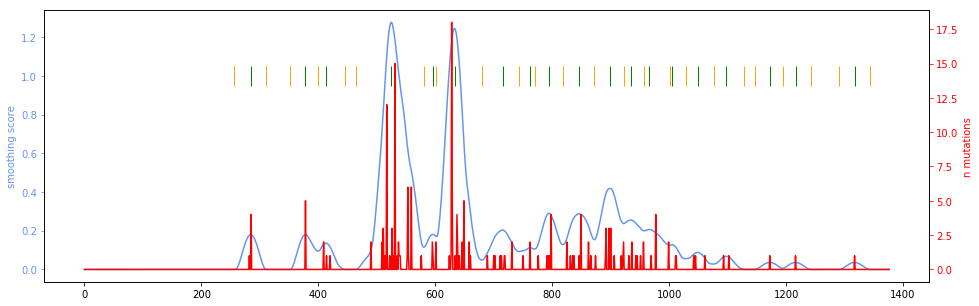

In [14]:
# Plot results
plt.figure(figsize=(20, 5))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=4)

ax1.plot(binary, c='cornflowerblue')
ax1.set_ylabel('smoothing score', color='cornflowerblue')

ax2 = ax1.twinx()
ax2.plot(mutations, c='red')
ax2.set_ylabel('n mutations', color='red')

ax1.plot(plot_max,'|', ms=20, c='green')
ax1.plot(plot_min,'|', ms=20, c='orange')

length = len(genomic)

ax1.tick_params('y', colors='cornflowerblue')
ax2.tick_params('y', colors='red')

### Define clusters

In [34]:
def cluster(indexes, window, mutations, scoring):
    """
    Find clusters and score them. 
    Scoring function: sum of scores of each position within the cluster. The score by position (i) is defined as: 
    fraction of mutations (i) / sqrt(2) ** distance(i - position max n mutations or max smoothing)
    Fraction of mutations by position is the percentage of the number of mutations observed in the position out 
    of the total number of mutations observed in the analyzed region across samples. 
            
    :param indexes: list of lists [0 == min or 1 == max, position in cds, smoothing score]
    :param window: integer. Expands the right minimum (right border) of a cluster to search for nearer clusters
    :param scoring: choose one scoring function, "mutation" or "smoothing". 
        mutation: the scoring function calculates the distance from the evaluated nucleotide to the position of maximum 
        number of mutations within the cluster. 
        smoothing: the scoring function calculates the distance from the evaluated nucleotide to the maximum peak of the
        scoring function within the cluster. 
        
    return: 
        clusters_d: dictionary of dictionaries. Contains clusters named by descending order of positions in the 
        studied region. Clusters contain: max, min_left, min_right. Each of them has a list with the position in the 
        region and the smoothing score. 
    """

    total_maxs = []
    clusters_d = defaultdict(dict)

    # Get a list of maximums sorted by position
    for element in indexes: 
        if element[0] == 1: 
            total_maxs.append(element[1])

    total_maxs_set = set(total_maxs)


    # Generate raw clusters: cluster: min_left, max, min:right. 
    # Name clusters by position, from 0 to len(maxs)-1 (integer >= 0 )
    # Add filter? (ex. clusters wit max > smoothing score of 1 mutation)
    j = 0
    for i in range(0, len(indexes)-2): 
        if indexes[i][0] == 0 and indexes[i+1][0] == 1:
            clusters_d[j]['min_l'] = [indexes[i][1], indexes[i][2]]
            clusters_d[j]['max'] = [indexes[i+1][1], indexes[i+1][2]]
            clusters_d[j]['min_r'] = [indexes[i+2][1], indexes[i+2][2]]
            j+=1

    # Merge the clusters
    iterations = len(clusters_d.keys())  
    iterate = 1

    # Iterate until no clusters_d updates occur
    while iterate != 0: 
        stop = set()
        
        # Iterate through initial number of clusters 
        # IMPROVE? 
        for i in range(iterations): 
            
            # When i is a key in clusters_d == when i is a cluster
            if i in clusters_d: 
                # Define the interval of search
                search_r = set(range(clusters_d[i]['max'][0] + 1, clusters_d[i]['min_r'][0] + window + 1))

                # When the intersection betweem the positions of the search and the maximums is not empty
                if search_r.intersection(total_maxs_set) != set(): 
                    # Analyze only the closest max
                    intersect_max = total_maxs.index(list(search_r.intersection(total_maxs_set))[0]) # sort / assume its sorted?
                    stop.add(1)
                    
                    # When the testing max is greater or equal than the intersected max, 
                    # expand the right border and delete intersected cluster from clusters_d
                    if clusters_d[i]['max'][1] >= clusters_d[intersect_max]['max'][1]:
                        clusters_d[i]['min_r'] = clusters_d[intersect_max]['min_r'] 
                        del clusters_d[intersect_max]
                        total_maxs_set.remove(total_maxs[intersect_max])


                    # When the testing max is smaller than the intersected max, 
                    # expand the left border of intersected max and remove the testing cluster (i)
                    elif clusters_d[i]['max'][1] < clusters_d[intersect_max]['max'][1]:
                        clusters_d[intersect_max]['min_l'] = clusters_d[i]['min_l']
                        del clusters_d[i]
                        total_maxs_set.remove(total_maxs[intersect_max])

        if stop == set(): 
                iterate = 0
                
    # Score clusters
    root = m.sqrt(2)

    if scoring == "smoothing"
        for cluster, values in clusters_d.items():
        score = 0

        for position in range(values['min_l'][0], values['min_r'][0] + 1):  # includes mins
            fraction_mut = (mutations[position] / len(mutations))*100
            distance = abs(position - values['max'][0]) 
            score += (fraction_mut /  m.pow(root, distance))

        # Update score
        clusters_d[cluster]['score'] = score
    
    
    elif scoring == "mutation": 
        indices = [i for i, x in enumerate(mutations) if x > 0]

        for cluster, values in clusters_d.items():
            
            # For each cluster, find position with max number of mutations
            interval_mut = range(values['min_l'][0] + 1, values['min_r'][0]) # don't includes mins
            cluster_mutations_in = list(filter(lambda x: x in interval_mut, indices))

            cluster_mutations_val = [] 
            for element in cluster_mutations_in: 
                cluster_mutations_val.append((element, mutations[element])) 
            max_mutation_index = max(cluster_mutations_val, key=lambda x:x[1])

            clusters_d[cluster]['max_mut'] = max_mutation_index[0] # What if cluster with positions with same number of mutations???  
            
            # Score cluster
            score = 0
            for position in range(values['min_l'][0], values['min_r'][0] + 1): # includes mins
                fraction_mut = (mutations[position] / len(mutations))*100
                distance = abs(position - values['max_mut'] )
                score += fraction_mut / m.pow(root, distance)
            # Update score
            clusters_d[cluster]['score'] = score
    
 
    return clusters_d

In [35]:
clusters_d = cluster(indexes=indexes, window=20, mutations=mutations, scoring="mutation")

In [39]:
# plot clusters

plot_max_2 = np.zeros(len(binary))
plot_min_l = np.zeros(len(binary))
plot_min_r = np.zeros(len(binary))

for key, value in clusters_d.items(): 
    plot_max_2[value['max'][0]]+=1
    plot_min_l[value['min_l'][0]]+=1
    plot_min_r[value['min_r'][0]]+=1

    # Change 0 to nan for matplotlib        
plot_max_2[ plot_max_2==0.0 ] = np.nan
plot_min_l[ plot_min_l==0.0 ] = np.nan 
plot_min_r[ plot_min_r==0.0 ] = np.nan

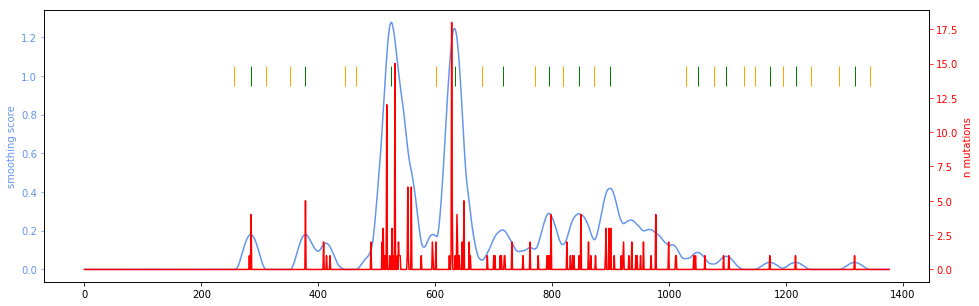

In [40]:
plt.figure(figsize=(20, 5))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=4)

ax1.plot(binary, c='cornflowerblue')
ax1.set_ylabel('smoothing score', color='cornflowerblue')

ax2 = ax1.twinx()
ax2.plot(mutations, c='red')
ax2.set_ylabel('n mutations', color='red')

ax1.plot(plot_max_2,'|', ms=20, c='green')
ax1.plot(plot_min_l,'|', ms=20, c='orange')
ax1.plot(plot_min_r,'|', ms=20, c='orange')

length = len(genomic)

ax1.tick_params('y', colors='cornflowerblue')
ax2.tick_params('y', colors='red')

In [37]:
# score by smoothing max

root = m.sqrt(2)

for cluster, values in clusters_d.items():
        score = 0

        for position in range(values['min_l'][0], values['min_r'][0] + 1):  # includes mins
            fraction_mut = (mutations[position] / len(mutations))*100
            distance = abs(position - values['max'][0]) 
            score += (fraction_mut /  m.pow(root, distance))

        # Update score
        clusters_d[cluster]['score'] = score

In [38]:
for cluster, value in clusters_d.items(): 
    print(cluster, value['score'])

0 0.241715840577
1 0.363111652136
3 0.401950078667
5 0.497805601251
6 0.100077439323
8 0.258722824748
9 0.131941700209
10 0.344751929078
14 0.0257090303303
15 0.0309932240593
16 0.0726216412491
17 0.0726216412491
18 0.0726216412491


In [31]:
# score by mutation max

root = m.sqrt(2)

for cluster, values in clusters_d.items():
    score = 0

    for position in range(values['min_l'][0], values['min_r'][0] + 1): # includes mins
        fraction_mut = (mutations[position] / len(mutations))*100
        distance = abs(position - values['max_mut'] )
        score += fraction_mut / m.pow(root, distance)

    # Update score
    clusters_d[cluster]['score'] = score
    


In [32]:
for cluster, value in clusters_d.items(): 
    print(cluster, value['score'])

0 0.31616219249
1 0.363111652136
3 1.22584478258
5 1.66238388814
6 0.147501283345
8 0.349849674618
9 0.319846878694
10 0.295208213264
14 0.0983975641631
15 0.0758310946859
16 0.0726216412491
17 0.0726216412491
18 0.0726216412491
